In [261]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import os
import itertools, random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold


In [ ]:
!wget https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/Xtrain.mat

In [114]:
# download training data
data = scipy.io.loadmat('Xtrain.mat')
x = data['Xtrain'].flatten() 
print("Data shape:", x.shape)

Data shape: (1000,)


### Analyzing training data

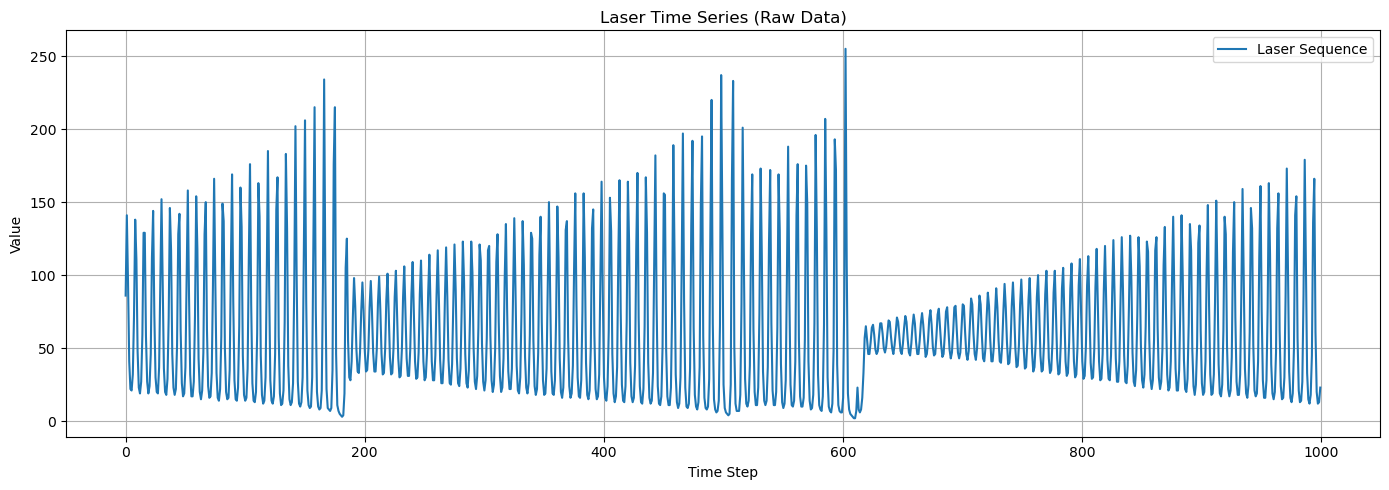

In [115]:
plt.figure(figsize=(14, 5))
plt.plot(x, label='Laser Sequence')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Laser Time Series (Raw Data)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [116]:
# Gaussian (Z-score) normalization
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.reshape(-1, 1)).flatten()

In [118]:
# make sequences of training data of length k+1,
# where k is the number of training instances and the k+1th instance is the test instance (iterative prediction)

def create_sequences(data, k):
    """
    data: 1‑D array (length N)
    k   : look‑back window
    returns:
      X – shape (N‑k, k, 1)
      y – shape (N‑k,)
    """
    X, y = [], []
    for i in range(len(data) - k):
        X.append(data[i : i + k])   # window of k past points
        y.append(data[i + k])       # next point
    X = np.array(X).reshape(-1, k, 1)   # 3‑D for LSTM
    return X.astype(np.float32), np.array(y).astype(np.float32)


In [ ]:
# LSTM model architecture

def build_lstm(k, n_units, n_layers, dropout, lr, reg=0.0):
    model = Sequential()
    for layer in range(n_layers):
        return_sequences = layer < n_layers - 1
        model.add(LSTM(n_units,
                       return_sequences=return_sequences,
                       input_shape=(k, 1),
                       kernel_regularizer=l2(reg) if reg > 0 else None,
                       recurrent_regularizer=l2(reg) if reg > 0 else None))
        
        if dropout:                       
            model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mse',
                  metrics=[MeanAbsoluteError()])
    return model

# Hyperparameter tuning

In [119]:
# hyperparameter search grid
k_values      = range(200, 260, 10)       
n_units_grid  = [8, 16]
n_layers_grid = [1, 2]
dropout_grid  = [0]
lr_grid       = [0.001, 0.003, 0.0005]
reg_grid      = [0, 0.0001]

full_grid   = list(itertools.product(k_values,
                                     n_units_grid,
                                     n_layers_grid,
                                     dropout_grid,
                                     lr_grid,
                                     reg_grid))
random.seed(42)
sampled_grid = random.sample(full_grid, k=50) 


In [248]:
# grid search for best hyperparameter combination

best_combo = None
best_score = float('inf')

for (k, n_units, n_layers, drop, lr, reg) in sampled_grid:
    X_all, y_all = create_sequences(x_scaled, k)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_losses = []

    for train_idx, val_idx in kf.split(X_all):
        X_train, X_val = X_all[train_idx], X_all[val_idx]
        y_train, y_val = y_all[train_idx], y_all[val_idx]

        model = build_lstm(k, n_units, n_layers, drop, lr, reg)
        model.fit(X_train, y_train,
                  epochs=20,
                  verbose=0)
        mse, _ = model.evaluate(X_val, y_val, verbose=0)
        cv_losses.append(mse)

    mean_cv = np.mean(cv_losses)
    print(f"{k=}, {n_units=}, {n_layers=}, {drop=:.2f}, {lr:.0e}, {reg:.0e} mse={mean_cv:.4f}")

    if mean_cv < best_score:
        best_score = mean_cv
        best_combo = (k, n_units, n_layers, drop, lr)

print("\nBest:", best_combo, "->", best_score)


In [ ]:
best_combo = 250, 32, 1, 0, 0.003
best_k = 250

## Further fine-tuning lookback values (k)

Evaluating k = 10


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  --> Mean MSE: 0.0313
Evaluating k = 50
  --> Mean MSE: 0.0506
Evaluating k = 100
  --> Mean MSE: 0.0284
Evaluating k = 150
  --> Mean MSE: 0.0276
Evaluating k = 200
  --> Mean MSE: 0.0423
Evaluating k = 250
  --> Mean MSE: 0.0334
Evaluating k = 300
  --> Mean MSE: 0.0712
Evaluating k = 350
  --> Mean MSE: 0.0495

Best k based on cross-validated MSE: 150 (MSE = 0.0276)


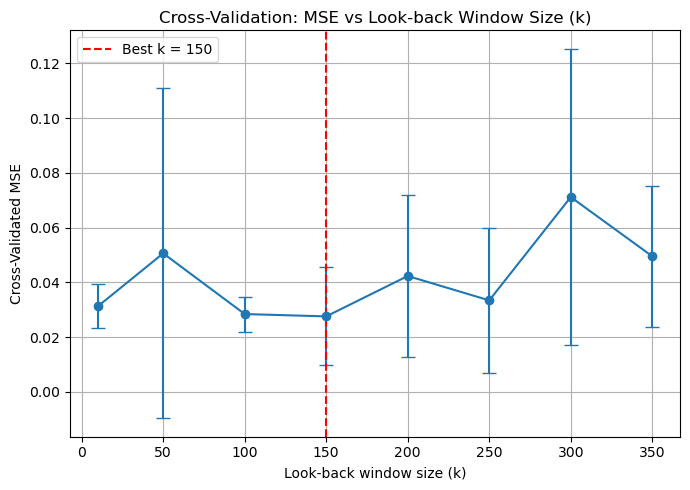

In [249]:
k_values = [10, 50, 100, 150, 200, 250, 300, 350]  
k_results = []

for k in k_values:
    print(f"Evaluating k = {k}")
    X_all, y_all = create_sequences(x_scaled, k)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_mse = []

    for train_idx, val_idx in kf.split(X_all):
        X_train, X_val = X_all[train_idx], X_all[val_idx]
        y_train, y_val = y_all[train_idx], y_all[val_idx]

        model = build_lstm(k, best_combo[1], best_combo[2], best_combo[3], best_combo[4])
        model.compile(optimizer=Adam(learning_rate=best_combo[4]),
                      loss='mse',
                      metrics=[MeanAbsoluteError()])

        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=0)
        val_mse, _ = model.evaluate(X_val, y_val, verbose=0)
        fold_mse.append(val_mse)

    avg_mse = np.mean(fold_mse)
    std_mse = np.std(fold_mse)
    k_results.append((k, avg_mse, std_mse))
    print(f"  --> Mean MSE: {avg_mse:.4f}")

best_k, best_mse, _ = min(k_results, key=lambda x: x[1])
print(f"\nBest k based on cross-validated MSE: {best_k} (MSE = {best_mse:.4f})")

k_vals, mean_losses, std_losses = zip(*k_results)
plt.figure(figsize=(7, 5))
plt.errorbar(k_vals, mean_losses, yerr=std_losses, fmt='-o', capsize=5)
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel("Look-back window size (k)")
plt.ylabel("Cross-Validated MSE")
plt.title("Cross-Validation: MSE vs Look-back Window Size (k)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('k_vs_loss.png')

plt.show()

## 5-Fold Cross-Validation

In [235]:
best_k = 250
X_all, y_all = create_sequences(x_scaled, best_k)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = []
train_mses, train_maes, val_mses, val_maes = [], [], [], []
histories = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_all), 1):
    X_train, X_val = X_all[train_idx], X_all[val_idx]
    y_train, y_val = y_all[train_idx], y_all[val_idx]

    model = build_lstm(best_k, best_combo[1], best_combo[2], best_combo[3], best_combo[4])
    model.compile(optimizer=Adam(learning_rate=best_combo[4]),
                  loss='mse',
                  metrics=[MeanAbsoluteError()])

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=50, verbose=0)
    histories.append(history)
    
    models.append(model)

    train_mse, train_mae = model.evaluate(X_train, y_train, verbose=0)
    val_mse, val_mae = model.evaluate(X_val, y_val, verbose=0)
    
    train_mses.append(train_mse)
    train_maes.append(train_mae)
    val_mses.append(val_mse)
    val_maes.append(val_mae)

    print(f"Fold {fold} - Training Loss (MSE): {train_mse:.4f}")
    print(f"Fold {fold} - Training MAE: {train_mae:.4f}")
    print(f"Fold {fold} - Validation Loss (MSE): {val_mse:.4f}")
    print(f"Fold {fold} - Validation MAE: {val_mae:.4f}")


avg_train_loss = np.mean(train_mses)
avg_train_mae = np.mean(train_maes)
avg_val_loss = np.mean(val_mses)
avg_val_mae = np.mean(val_maes)

print(f"\n=== Average Results Across All Folds ===")
print(f"Average Training Loss (MSE): {avg_train_loss:.4f}")
print(f"Average Training MAE: {avg_train_mae:.4f}")
print(f"Average Validation Loss (MSE): {avg_val_loss:.4f}")
print(f"Average Validation MAE: {avg_val_mae:.4f}")


Fold 1 - Training Loss (MSE): 0.0012
Fold 1 - Training MAE: 0.0242
Fold 1 - Validation Loss (MSE): 0.1993
Fold 1 - Validation MAE: 0.0959
Fold 2 - Training Loss (MSE): 0.0029
Fold 2 - Training MAE: 0.0381
Fold 2 - Validation Loss (MSE): 0.0336
Fold 2 - Validation MAE: 0.0651
Fold 3 - Training Loss (MSE): 0.0056
Fold 3 - Training MAE: 0.0388
Fold 3 - Validation Loss (MSE): 0.0060
Fold 3 - Validation MAE: 0.0419
Fold 4 - Training Loss (MSE): 0.0052
Fold 4 - Training MAE: 0.0415
Fold 4 - Validation Loss (MSE): 0.0087
Fold 4 - Validation MAE: 0.0473
Fold 5 - Training Loss (MSE): 0.0052
Fold 5 - Training MAE: 0.0431
Fold 5 - Validation Loss (MSE): 0.0031
Fold 5 - Validation MAE: 0.0348

=== Average Results Across All Folds ===
Average Training Loss (MSE): 0.0040
Average Training MAE: 0.0372
Average Validation Loss (MSE): 0.0501
Average Validation MAE: 0.0570


/var/folders/qc/8fy08h5s33n4rrmz09_8bv680000gn/T/ipykernel_19059/225220624.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_folds, 2, 2*i + 1)


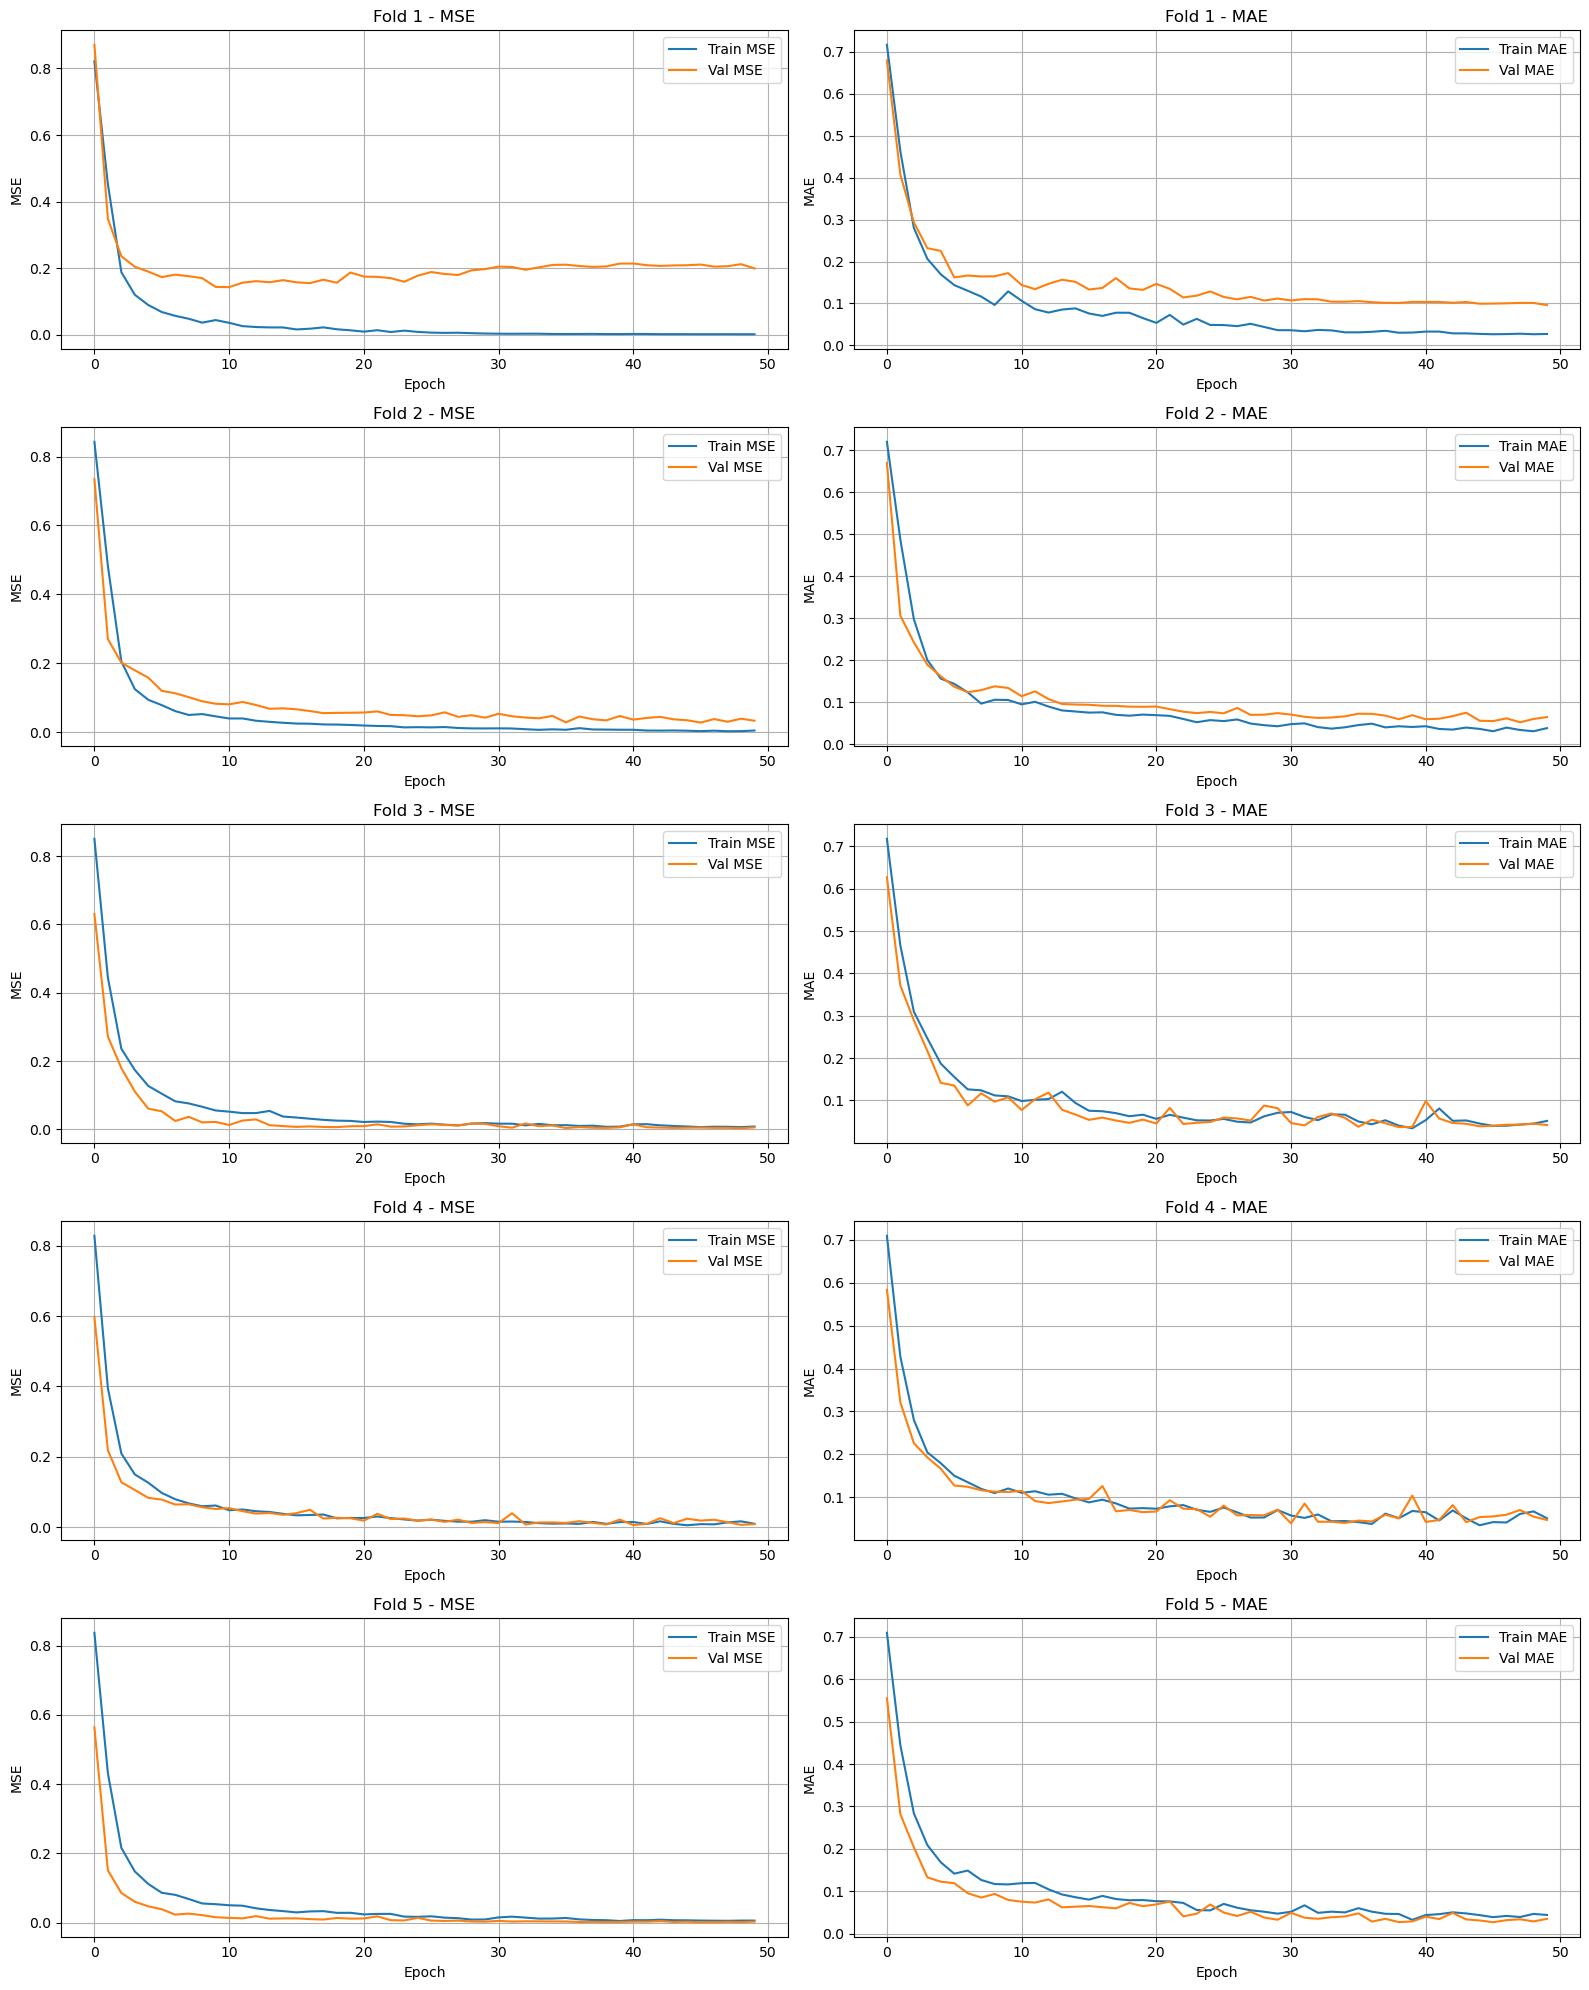

In [236]:
# plotting the validation vs. training loss curve for each CV fold 

num_folds = len(histories)
plt.figure(figsize=(16, 4 * num_folds))
plt.title("5-Fold Cross Validation (LSTM)")

for i, history in enumerate(histories):

    plt.subplot(num_folds, 2, 2*i + 1)
    plt.plot(history.history['loss'], label='Train MSE')
    plt.plot(history.history['val_loss'], label='Val MSE')
    plt.title(f'Fold {i+1} - MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.subplot(num_folds, 2, 2*i + 2)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
    plt.title(f'Fold {i+1} - MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Qualitative training evaluation


In [ ]:
# function to predict the next n predictions iteratively
def predict_next(model, train_set, test_set, lookback, n_pred=200):
  """
  test_set: scaled test data
  train_set: scaled train data
  """
  full_set = np.concatenate([train_set, test_set])

  current_input = full_set[len(train_set)-lookback:len(train_set)].reshape(1, lookback, 1) # start from the last values of the training set

  predictions = []

  for i in range(n_pred):
      next_val = model.predict(current_input, verbose=0)[0, 0]
      predictions.append(next_val)
      current_input = np.append(current_input[:, 1:, :], [[[next_val]]], axis=1)
      # print(current_input.shape)

  return predictions

# function to plot and evaluate the predictions against the test set

def pred_eval_pipeline(model, train_set, test_set, lookback, scale=False, n_pred=200):

  """Assumes train and test set are pre-scaled"""

  preds = predict_next(model, train_set, test_set, lookback, n_pred)

  # unscale predictions and true values
  preds = predict_next(model, train_set, test_set, lookback)
  preds_orig = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
  test_set_orig = scaler.inverse_transform(test_set.reshape(-1, 1)).flatten()

  # plot predicted vs. true values
  plt.figure(figsize=(12, 5))
  plt.plot(test_set_orig, label='True Values')
  plt.plot(preds_orig, label='Predictions')
  plt.title('Predictions vs. True Values')
  plt.xlabel('Time Step')
  plt.ylabel('Scaled Value')
  plt.legend()
  plt.grid(True)
  plt.show()

  # print evaluation metrics
  mae = mean_absolute_error(test_set_orig, preds_orig)
  mse = mean_squared_error(test_set_orig, preds_orig)
  print(f"MAE: {mae:.6f}")
  print(f"MSE: {mse:.6f}")

In [256]:
#  plot the next 200 time-step predictions based on CV models to observe whether it is able to predict a cyclical pattern (with dips)
train_set = x_scaled
X_train, y_train = create_sequences(train_set, best_k)
train_original = scaler.inverse_transform(train_set.reshape(-1, 1)).flatten()
train_len = len(train_set) 

# loop through all trained models trained during cross-validation
for i, model in enumerate(models):
    print(f"\nPredicting next 200 steps with model {i + 1}")

    preds = predict_next(model, train_set, [], best_k)
    preds_orig = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

    prediction_timeline = np.arange(train_len, train_len + len(preds_orig))

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(train_original, label='Training Data', color='gray')
    plt.plot(prediction_timeline, preds_orig, label=f'Predicted Future (Model {i + 1})', color='red', linestyle='--')
    plt.title(f"MLP Forecast with Model {i + 1}: Next 200 Time Steps")
    plt.xlabel("Time Step")
    plt.ylabel("Original Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

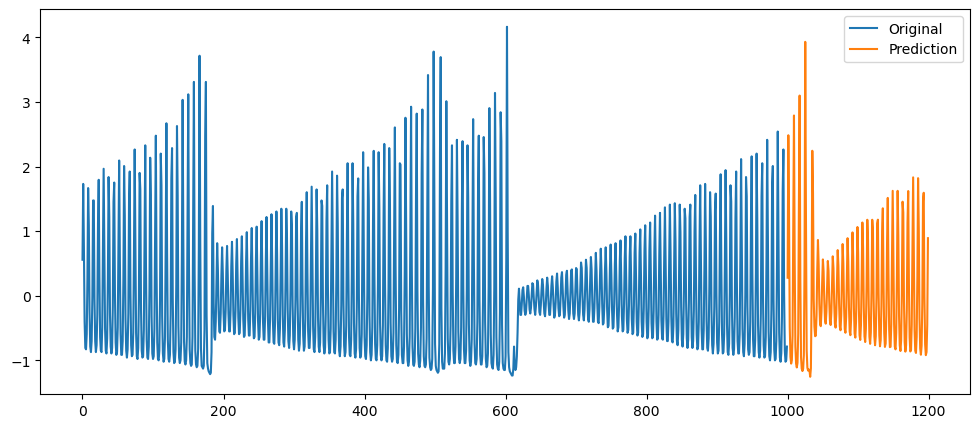

In [ ]:
# train best model on all data
k= 250
X_train,y_train = create_sequences(x_scaled[:800], k)

final_model = build_lstm(250, 32, 1, 0, 0.003)
final_model.compile(optimizer=Adam(learning_rate=best_combo[4]),
                    loss='mse',
                    metrics=[MeanAbsoluteError()])
final_model.fit(X_train, y_train, epochs=50, verbose=0)

p = predict_next(final_model, x_scaled, [], best_k, n_pred=200)


plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(x_scaled)), x_scaled, label="Original")
plt.plot(np.arange(len(x_scaled), len(x_scaled) + len(p)), p, label="Prediction")

plt.legend()
plt.show()

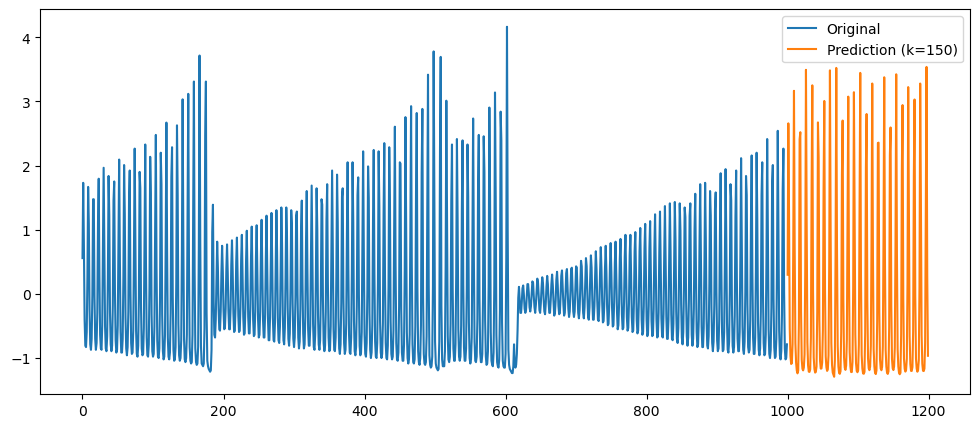

In [252]:
# show predictions of a model trained with the same parameters but smaller k (=150)
k= 150
X_train,y_train = create_sequences(x_scaled[:800], k)

final_model = build_lstm(250, 32, 1, 0, 0.003)
final_model.compile(optimizer=Adam(learning_rate=best_combo[4]),
                    loss='mse',
                    metrics=[MeanAbsoluteError()])
final_model.fit(X_train, y_train, epochs=50, verbose=0)

p = predict_next(final_model, x_scaled, [], best_k, n_pred=200)


plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(x_scaled)), x_scaled, label="Original")
plt.plot(np.arange(len(x_scaled), len(x_scaled) + len(p)), p, label="Prediction (k=150)")

plt.legend()
plt.show()

## Save models

In [ ]:
# os.makedirs("models", exist_ok=True)

# # Save each model to a separate .h5 file
# for i, model in enumerate(models):
#     model.save(f"models/lstm_model_fold_{i + 1}.h5")
#     print(f"Model {i + 1} saved to models/lstm_model_fold_{i + 1}.h5")

# final_model.save(f"models/lstm_final_model.h5")

# Test Set Evaluation

In [258]:
# load test set
!wget https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/Xtest.mat

# load all trained models 
!wget https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/LSTM/models/lstm_final_model.h5
!wget https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/LSTM/models/lstm_model_fold_1.h5
!wget https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/LSTM/models/lstm_model_fold_2.h5
!wget https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/LSTM/models/lstm_model_fold_3.h5
!wget https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/LSTM/models/lstm_model_fold_4.h5
!wget https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/LSTM/models/lstm_model_fold_5.h5

--2025-05-09 21:47:28--  https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/Xtest.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 376 [application/octet-stream]
Saving to: ‘Xtest.mat.1’

Xtest.mat.1         100%[===================>]     376  --.-KB/s    in 0s      

2025-05-09 21:47:29 (12,8 MB/s) - ‘Xtest.mat.1’ saved [376/376]

--2025-05-09 21:47:29--  https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/LSTM/models/lstm_final_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HT

In [259]:
# load train and test data 
train_data = scipy.io.loadmat('Xtrain.mat')
test_data = scipy.io.loadmat('Xtest.mat')
train_x = train_data['Xtrain'].flatten() 
test_x = test_data['Xtest'].flatten()
print("Train data shape:", train_x.shape)
print("Test data shape:", test_x.shape)

# train scaler on the train set and apply on the test set
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x.reshape(-1, 1)).flatten()
test_x_scaled = scaler.transform(test_x.reshape(-1, 1)).flatten()

Train data shape: (1000,)
Test data shape: (200,)


In [269]:
model_1 = load_model("Assignment 1/LSTM/models/lstm_final_model.h5", compile=False)
model_2 = load_model("Assignment 1/LSTM/models/lstm_model_fold_1.h5", compile=False)
model_3 = load_model("Assignment 1/LSTM/models/lstm_model_fold_2.h5", compile=False)
model_4 = load_model("Assignment 1/LSTM/models/lstm_model_fold_3.h5", compile=False) # best CV model 
model_5 = load_model("Assignment 1/LSTM/models/lstm_model_fold_4.h5", compile=False)
final_model = load_model("Assignment 1/LSTM/models/lstm_final_model.h5", compile=False) # trained on the whole dataset

## Trained on the whole dataset

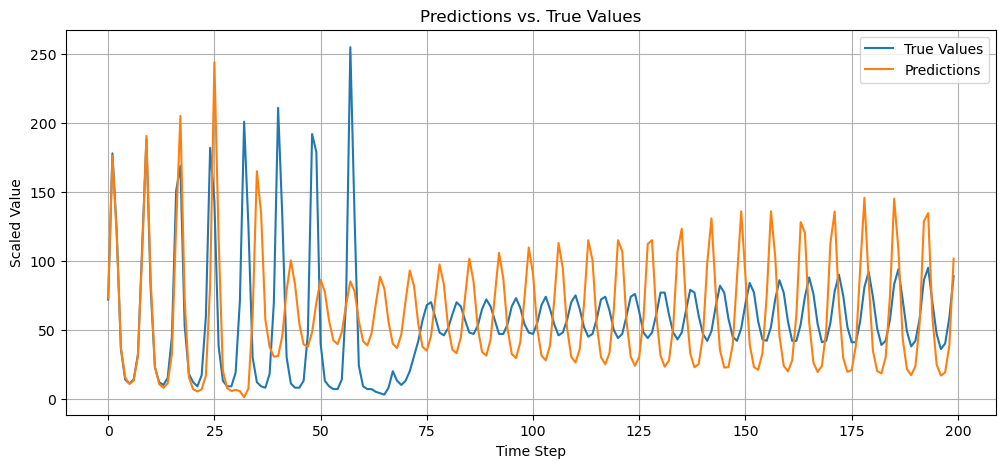

MAE: 37.764470
MSE: 2525.170550


In [270]:
pred_eval_pipeline(final_model, train_x_scaled, test_x_scaled, 250)

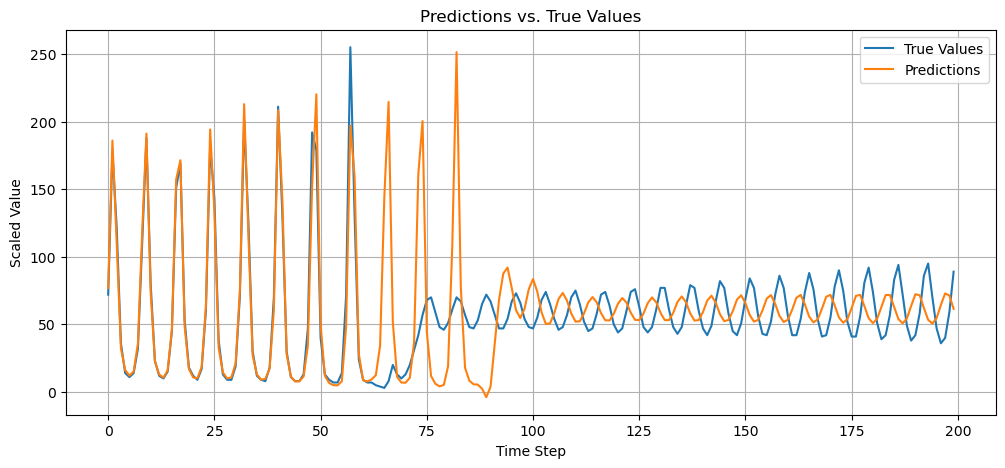

MAE: 20.025865
MSE: 1122.039280


In [271]:
pred_eval_pipeline(model_4, train_x_scaled, test_x_scaled, 250)

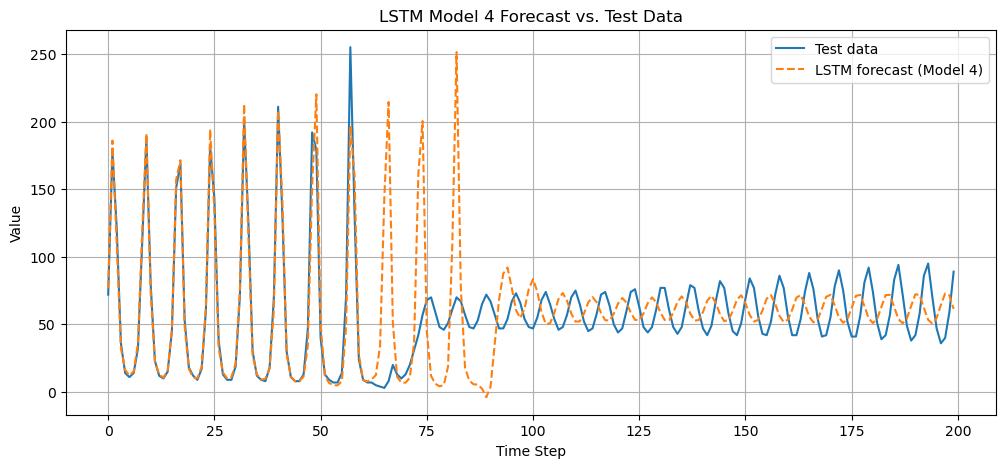

MAE: 20.025865
MSE: 0.000000


In [272]:
# Make a nice plot the best prediction (model 4)
best_preds = predict_next(model_4, train_x_scaled, test_x_scaled, 250)

best_preds_orig = scaler.inverse_transform(np.array(best_preds).reshape(-1, 1)).flatten()
test_set_orig = scaler.inverse_transform(test_x_scaled.reshape(-1, 1)).flatten()

# plot predicted vs. true values
plt.figure(figsize=(12, 5))
plt.plot(test_set_orig, label='Test data')
plt.plot(best_preds_orig, label='LSTM forecast (Model 4)',linestyle='dashed')
plt.title('LSTM Model 4 Forecast vs. Test Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# print evaluation metrics
mae = mean_absolute_error(test_set_orig, best_preds_orig)
mse = mean_squared_error(test_set_orig, test_set_orig)
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")